In [4]:
import cv2
import mediapipe as mp
import numpy as np
import os
from scipy.spatial import distance

In [15]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Folder with videos
VIDEO_DIR = "/kaggle/input/supine-leg-raises/Videos"  # Replace with your video folder path
OUTPUT_DIR = "preprocessed_data_supine_leg_raises"   # Where to save processed sequences
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Parameters
FRAME_RATE = 30          # Adjust based on your videos (frames per second)
WINDOW_SIZE = 15         # Number of frames per sequence for LSTM (e.g., ~0.5s at 30fps)
STRIDE = 5               # Step size between sequences
MIN_CONFIDENCE = 0.5     # Filter low-confidence keypoints
N_FEATURES = 3           # Knee angle, knee velocity, hip-knee distance

In [8]:
# Helper function to calculate angle between three points
def calculate_angle(p1, p2, p3):
    v1 = np.array(p1) - np.array(p2)  # Vector from p2 to p1
    v2 = np.array(p3) - np.array(p2)  # Vector from p2 to p3
    cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))
    return angle

# Helper function to mirror keypoints (right leg to left leg)
def mirror_keypoints(keypoints, frame_width):
    mirrored = keypoints.copy()
    # Flip x-coordinates: x_new = frame_width - x_old
    for i in range(len(mirrored)):
        mirrored[i, 0] = frame_width - mirrored[i, 0]
    # Swap left and right indices (e.g., left knee becomes right knee)
    left_indices = [11, 13, 15, 23, 25, 27]  # Hip, knee, ankle (left)
    right_indices = [12, 14, 16, 24, 26, 28] # Hip, knee, ankle (right)
    for left_idx, right_idx in zip(left_indices, right_indices):
        mirrored[left_idx], mirrored[right_idx] = mirrored[right_idx].copy(), mirrored[left_idx].copy()
    return mirrored

# Process a single video
def process_video(video_path, exercise_name="straight_leg_raise"):
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    all_features = []  # Store features per frame

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert BGR to RGB for MediaPipe
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            # Extract keypoints (x, y, z, visibility)
            keypoints = np.array([[lm.x, lm.y, lm.z, lm.visibility] 
                                 for lm in results.pose_landmarks.landmark])

            # Filter low-confidence keypoints
            if np.mean(keypoints[:, 3]) < MIN_CONFIDENCE:
                continue

            # Detect active leg for Straight Leg Raise (based on knee y-movement)
            left_knee_y = keypoints[25, 1]  # Left knee (normalized 0-1)
            right_knee_y = keypoints[26, 1] # Right knee
            left_hip_y = keypoints[23, 1]
            right_hip_y = keypoints[24, 1]
            active_leg = "left" if (left_knee_y < left_hip_y - 0.1) else "right"  # Lifting leg rises above hip

            # Mirror right-leg to left-leg if needed
            if active_leg == "right":
                keypoints = mirror_keypoints(keypoints, frame_width)

            # Normalize keypoints relative to torso length (hip to shoulder)
            torso_length = distance.euclidean(keypoints[11, :2], keypoints[23, :2])  # Left shoulder to hip
            if torso_length == 0:  # Avoid division by zero
                continue
            keypoints[:, :2] /= torso_length  # Normalize x, y

            # Extract features (focus on active leg, assumed left after mirroring)
            left_hip = keypoints[23, :2]    # x, y
            left_knee = keypoints[25, :2]
            left_ankle = keypoints[27, :2]
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            knee_velocity = (left_knee[1] - all_features[-1][1]) * FRAME_RATE if all_features else 0  # Δy/sec
            hip_knee_dist = distance.euclidean(left_hip, left_knee) / torso_length

            # Feature vector: [knee_angle, knee_velocity, hip_knee_dist]
            features = np.array([knee_angle, knee_velocity, hip_knee_dist])
            all_features.append(features)

    cap.release()
    return np.array(all_features)

# Segment features into sequences for LSTM
def create_sequences(features, window_size=WINDOW_SIZE, stride=STRIDE):
    sequences = []
    for start in range(0, len(features) - window_size + 1, stride):
        seq = features[start:start + window_size]
        if len(seq) == window_size:  # Ensure full sequence
            sequences.append(seq)
    return np.array(sequences)

# Main preprocessing loop
def preprocess_all_videos():
    all_sequences = []
    video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(".mp4")]

    for idx, video_file in enumerate(video_files):
        video_path = os.path.join(VIDEO_DIR, video_file)
        print(f"Processing video {idx + 1}/{len(video_files)}: {video_file}")

        # Process video into per-frame features
        features = process_video(video_path, exercise_name="straight_leg_raise")
        if len(features) < WINDOW_SIZE:
            print(f"Skipping {video_file}: Too few frames")
            continue

        # Segment into sequences
        sequences = create_sequences(features)
        if len(sequences) > 0:
            all_sequences.append(sequences)
            np.save(os.path.join(OUTPUT_DIR, f"sequences_{idx}.npy"), sequences)
            print(f"Saved {len(sequences)} sequences from {video_file}")

    # Combine all sequences into one array
    if all_sequences:
        all_sequences = np.concatenate(all_sequences, axis=0)
        np.save(os.path.join(OUTPUT_DIR, "all_sequences.npy"), all_sequences)
        print(f"Total sequences: {len(all_sequences)}")
    return all_sequences

In [9]:
# Run preprocessing
if __name__ == "__main__":
    sequences = preprocess_all_videos()
    print(f"Shape of final data: {sequences.shape}")  # (n_sequences, window_size, n_features)

    # Clean up MediaPipe
    pose.close()

Processing video 1/69: michiganmedicine (online-video-cutter.com) - Copy (2).mp4


<ipython-input-8-27efc5c27425>:68: RuntimeWarning: overflow encountered in scalar multiply
  knee_velocity = (left_knee[1] - all_features[-1][1]) * FRAME_RATE if all_features else 0  # Δy/sec


Saved 146 sequences from michiganmedicine (online-video-cutter.com) - Copy (2).mp4
Processing video 2/69: Straight Leg Raise (3) - Copy.mp4
Saved 75 sequences from Straight Leg Raise (3) - Copy.mp4
Processing video 3/69: how-to-do-a-supine-active-straight-leg-raise-medbridge_HRBNL2Xz - Copy.mp4
Saved 58 sequences from how-to-do-a-supine-active-straight-leg-raise-medbridge_HRBNL2Xz - Copy.mp4
Processing video 4/69: Supine Straight Leg Raise (3) - Copy.mp4
Saved 31 sequences from Supine Straight Leg Raise (3) - Copy.mp4
Processing video 5/69: Straight Leg Raises (1).mp4
Saved 55 sequences from Straight Leg Raises (1).mp4
Processing video 6/69: aligneorthopedicandsports.mp4
Saved 149 sequences from aligneorthopedicandsports.mp4
Processing video 7/69: how-to-do-a-supine-active-straight-leg-raise-medbridge_HRBNL2Xz - Copy (2).mp4
Saved 58 sequences from how-to-do-a-supine-active-straight-leg-raise-medbridge_HRBNL2Xz - Copy (2).mp4
Processing video 8/69: how-to-do-a-supine-active-straight-le

## Model Training

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [12]:
# Normalize sequences for training
def normalize_sequences(sequences):
    # Normalize each feature across all sequences
    mean = np.mean(sequences, axis=(0, 1))
    std = np.std(sequences, axis=(0, 1))
    normalized = (sequences - mean) / (std + 1e-8)  # Avoid division by zero
    return normalized, mean, std

# Build and train LSTM-Autoencoder
def train_lstm_autoencoder(sequences):
    # Normalize data
    sequences_normalized, mean, std = normalize_sequences(sequences)
    print(f"Normalized sequences shape: {sequences_normalized.shape}")

    # Define model
    model = Sequential([
        LSTM(64, input_shape=(WINDOW_SIZE, N_FEATURES), return_sequences=False),
        Dense(32, activation='relu'),
        RepeatVector(WINDOW_SIZE),
        LSTM(64, return_sequences=True),
        TimeDistributed(Dense(N_FEATURES))
    ])
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    # Split into train and validation (80/20)
    split_idx = int(0.8 * len(sequences_normalized))
    train_data = sequences_normalized[:split_idx]
    val_data = sequences_normalized[split_idx:]

    # Train with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(train_data, train_data, 
                        epochs=100, 
                        batch_size=32, 
                        validation_data=(val_data, val_data), 
                        callbacks=[early_stopping],
                        verbose=1)

    # Save model and normalization stats
    model.save("lstm_autoencoder.h5")
    np.save(os.path.join(OUTPUT_DIR, "norm_mean.npy"), mean)
    np.save(os.path.join(OUTPUT_DIR, "norm_std.npy"), std)
    print("Model and normalization stats saved.")

    # Plot training history
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

    return model, mean, std

# Inference: Calculate reconstruction errors
def calculate_errors(model, sequences, mean, std):
    sequences_normalized = (sequences - mean) / (std + 1e-8)
    reconstructions = model.predict(sequences_normalized)
    errors = np.mean(np.square(sequences_normalized - reconstructions), axis=(1, 2))
    return errors

In [16]:
# Train LSTM-Autoencoder
print("Starting training...")
model, mean, std = train_lstm_autoencoder(sequences)

# 
errors = calculate_errors(model, sequences, mean, std)
print(f"Reconstruction errors: min={np.min(errors):.4f}, max={np.max(errors):.4f}, mean={np.mean(errors):.4f}")

# Calculate Suggested Threshold
error_threshold = np.mean(errors) + 2 * np.std(errors)
print(f"Suggested anomaly threshold: {error_threshold:.4f}")

Starting training...
Normalized sequences shape: (7849, 15, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 15, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 15, 3)               │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,515 (173.89 KB)

 Trainable params: 44,515 (173.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: nan - val_loss: nan
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 6/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 7/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 8/100
136/197 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan

KeyboardInterrupt: 

# Extracting Data from Video Dataset

In [3]:
import os
import csv
import cv2
import numpy as np
import mediapipe as mp
from tqdm import tqdm

In [4]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,  # Higher accuracy
    smooth_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

def extract_keypoints_from_videos(video_dir, output_csv_path):
    """
    Extract keypoints from all videos in a directory and save to CSV.
    Includes 3D coordinates (x, y, z) for each landmark.
    
    Args:
        video_dir (str): Directory containing video files
        output_csv_path (str): Path to save the CSV output
    """
    # Get all video files
    video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi', '.mov'))]
    
    # Create CSV file
    with open(output_csv_path, 'w', newline='') as csvfile:
        # Define headers: video_id, frame_number, followed by all landmarks
        fieldnames = ['video_id', 'frame_number']
        
        # Add all pose landmark points (33 landmarks x 4 values (x, y, z, visibility))
        for i in range(33):
            fieldnames.extend([f'landmark_{i}_x', f'landmark_{i}_y', f'landmark_{i}_z', f'landmark_{i}_vis'])
        
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        # Process each video
        for video_idx, video_file in enumerate(video_files):
            video_path = os.path.join(video_dir, video_file)
            video_id = f"video_{video_idx}_{os.path.splitext(video_file)[0]}"
            
            # Open video
            cap = cv2.VideoCapture(video_path)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            # Process each frame
            print(f"Processing video {video_idx+1}/{len(video_files)}: {video_file}")
            for frame_number in tqdm(range(frame_count)):
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Convert to RGB for MediaPipe
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Process frame
                results = pose.process(frame_rgb)
                
                # If pose landmarks detected
                if results.pose_landmarks and results.pose_world_landmarks:
                    row_data = {
                        'video_id': video_id,
                        'frame_number': frame_number
                    }
                    
                    # Extract all landmarks - image coordinates (x,y relative to image)
                    for i, landmark in enumerate(results.pose_landmarks.landmark):
                        row_data[f'landmark_{i}_x'] = landmark.x
                        row_data[f'landmark_{i}_y'] = landmark.y
                        row_data[f'landmark_{i}_vis'] = landmark.visibility
                        
                        # Get corresponding 3D world landmark (MediaPipe's 3D coordinates)
                        world_landmark = results.pose_world_landmarks.landmark[i]
                        row_data[f'landmark_{i}_z'] = world_landmark.z
                    
                    writer.writerow(row_data)
                else:
                    # If no landmarks detected, write ID and frame number with empty data
                    row_data = {
                        'video_id': video_id,
                        'frame_number': frame_number
                    }
                    for i in range(33):
                        row_data[f'landmark_{i}_x'] = None
                        row_data[f'landmark_{i}_y'] = None
                        row_data[f'landmark_{i}_z'] = None
                        row_data[f'landmark_{i}_vis'] = None
                    
                    writer.writerow(row_data)
            
            cap.release()
    
    print(f"Keypoints extraction complete. Data saved to {output_csv_path}")

## Running Extraction

In [5]:
# Extract keypoints from videos with 3D data
VIDEO_DIR = "/kaggle/input/supine-leg-raises/Videos"
OUTPUT_DIR = "SLR_keypoints_data.csv"

extract_keypoints_from_videos(VIDEO_DIR, OUTPUT_DIR)

Processing video 1/69: michiganmedicine (online-video-cutter.com) - Copy (2).mp4


100%|██████████| 880/880 [01:22<00:00, 10.68it/s]


Processing video 2/69: Straight Leg Raise (3) - Copy.mp4


100%|██████████| 387/387 [00:39<00:00,  9.84it/s]


Processing video 3/69: how-to-do-a-supine-active-straight-leg-raise-medbridge_HRBNL2Xz - Copy.mp4


100%|██████████| 324/324 [00:33<00:00,  9.67it/s]


Processing video 4/69: Supine Straight Leg Raise (3) - Copy.mp4


100%|██████████| 169/169 [00:17<00:00,  9.54it/s]


Processing video 5/69: Straight Leg Raises (1).mp4


100%|██████████| 286/286 [00:29<00:00,  9.71it/s]


Processing video 6/69: aligneorthopedicandsports.mp4


100%|██████████| 760/760 [01:17<00:00,  9.77it/s]


Processing video 7/69: how-to-do-a-supine-active-straight-leg-raise-medbridge_HRBNL2Xz - Copy (2).mp4


100%|██████████| 324/324 [00:33<00:00,  9.69it/s]


Processing video 8/69: how-to-do-a-supine-active-straight-leg-raise-medbridge_S8q9cpKR - Copy.mp4


100%|██████████| 253/253 [00:25<00:00,  9.75it/s]


Processing video 9/69: Straight Leg Raise Supine - Ask Doctor Jo (online-video-cutter.com) - Copy (3).mp4


100%|██████████| 474/474 [00:48<00:00,  9.72it/s]


Processing video 10/69: baptisthealth (online-video-cutter.com).mp4


100%|██████████| 570/570 [00:58<00:00,  9.71it/s]


Processing video 11/69: Straight Leg Raise Supine - Ask Doctor Jo (online-video-cutter.com) - Copy (2).mp4


100%|██████████| 474/474 [00:49<00:00,  9.67it/s]


Processing video 12/69: vitalrehabphysicaltherapy - Copy.mp4


100%|██████████| 540/540 [00:55<00:00,  9.65it/s]


Processing video 13/69: Supine Straight Leg Raise.mp4


100%|██████████| 96/96 [00:10<00:00,  9.15it/s]


Processing video 14/69: Supine Straight Leg Raise - Copy (2).mp4


100%|██████████| 96/96 [00:10<00:00,  9.29it/s]


Processing video 15/69: Supine Straight Leg Raise (2).mp4


100%|██████████| 169/169 [00:17<00:00,  9.41it/s]


Processing video 16/69: MGHOrtho - Copy (3).mp4


100%|██████████| 334/334 [00:35<00:00,  9.49it/s]


Processing video 17/69: Straight Leg Raise Supine - Ask Doctor Jo (online-video-cutter.com) - Copy.mp4


100%|██████████| 474/474 [00:49<00:00,  9.52it/s]


Processing video 18/69: performance_physical_therapy_and_sports_medicine.mp4


100%|██████████| 738/738 [01:16<00:00,  9.67it/s]


Processing video 19/69: coreymuggler-dpt - Copy (2).mp4


100%|██████████| 265/265 [00:27<00:00,  9.59it/s]


Processing video 20/69: Supine Straight Leg Raise - Copy.mp4


100%|██████████| 96/96 [00:10<00:00,  9.20it/s]


Processing video 21/69: coreymuggler-dpt - Copy.mp4


100%|██████████| 265/265 [00:28<00:00,  9.44it/s]


Processing video 22/69: how-to-do-a-supine-active-straight-leg-raise-medbridge_S8q9cpKR.mp4


100%|██████████| 253/253 [00:26<00:00,  9.57it/s]


Processing video 23/69: MyCompetitiveLife - Copy.mp4


100%|██████████| 689/689 [01:11<00:00,  9.60it/s]


Processing video 24/69: MGHOrtho - Copy.mp4


100%|██████████| 334/334 [00:34<00:00,  9.64it/s]


Processing video 25/69: MGHOrtho - Copy (2).mp4


100%|██████████| 334/334 [00:34<00:00,  9.74it/s]


Processing video 26/69: Straight Leg Raise (3).mp4


100%|██████████| 387/387 [00:38<00:00,  9.95it/s]


Processing video 27/69: Straight leg raise (1).mp4


100%|██████████| 173/173 [00:17<00:00,  9.85it/s]


Processing video 28/69: Supine Straight Leg Raise. (online-video-cutter.com) - Copy (2).mp4


100%|██████████| 1068/1068 [01:50<00:00,  9.70it/s]


Processing video 29/69: how-to-do-a-supine-active-straight-leg-raise-medbridge_HRBNL2Xz.mp4


100%|██████████| 324/324 [00:33<00:00,  9.71it/s]


Processing video 30/69: vitalrehabphysicaltherapy - Copy (2).mp4


100%|██████████| 540/540 [00:54<00:00,  9.88it/s]


Processing video 31/69: bouldersportschropractic - Copy.mp4


100%|██████████| 725/725 [01:13<00:00,  9.89it/s]


Processing video 32/69: Straight Leg Raise (5) - Copy.mp4


100%|██████████| 387/387 [00:38<00:00, 10.04it/s]


Processing video 33/69: Straight Leg Raises (2).mp4


100%|██████████| 286/286 [00:29<00:00,  9.76it/s]


Processing video 34/69: michiganmedicine (online-video-cutter.com) - Copy.mp4


100%|██████████| 880/880 [01:22<00:00, 10.63it/s]


Processing video 35/69: HEATPT - Copy (2).mp4


100%|██████████| 252/252 [00:26<00:00,  9.62it/s]


Processing video 36/69: Straight leg raise.mp4


100%|██████████| 173/173 [00:18<00:00,  9.54it/s]


Processing video 37/69: Supine Straight Leg Raise. (online-video-cutter.com).mp4


100%|██████████| 1068/1068 [01:52<00:00,  9.53it/s]


Processing video 38/69: aligneorthopedicandsports - Copy (2).mp4


100%|██████████| 760/760 [01:20<00:00,  9.50it/s]


Processing video 39/69: Straight Leg Raise Supine - Ask Doctor Jo (online-video-cutter.com).mp4


100%|██████████| 474/474 [00:50<00:00,  9.35it/s]


Processing video 40/69: dramitshirawas (2).mp4


100%|██████████| 778/778 [01:20<00:00,  9.71it/s]


Processing video 41/69: HEATPT - Copy.mp4


100%|██████████| 252/252 [00:25<00:00,  9.76it/s]


Processing video 42/69: aligneorthopedicandsports - Copy.mp4


100%|██████████| 760/760 [01:19<00:00,  9.57it/s]


Processing video 43/69: MyCompetitiveLife - Copy (2).mp4


100%|██████████| 689/689 [01:11<00:00,  9.70it/s]


Processing video 44/69: how-to-do-a-supine-active-straight-leg-raise-medbridge_HRBNL2Xz - Copy (3).mp4


100%|██████████| 324/324 [00:33<00:00,  9.79it/s]


Processing video 45/69: kinetxx_FlpEfoeB.mp4


100%|██████████| 5579/5579 [09:03<00:00, 10.27it/s]


Processing video 46/69: how-to-do-a-supine-active-straight-leg-raise-medbridge_S8q9cpKR - Copy (3).mp4


100%|██████████| 253/253 [00:25<00:00,  9.73it/s]


Processing video 47/69: reboundPT.mp4


100%|██████████| 1368/1368 [02:19<00:00,  9.78it/s]


Processing video 48/69: MGHOrtho.mp4


100%|██████████| 334/334 [00:34<00:00,  9.79it/s]


Processing video 49/69: BSR_physical_therapy - Copy.mp4


100%|██████████| 858/858 [01:27<00:00,  9.77it/s]


Processing video 50/69: michiganmedicine (online-video-cutter.com).mp4


100%|██████████| 880/880 [01:21<00:00, 10.74it/s]


Processing video 51/69: Straight Leg Raise (4) - Copy.mp4


100%|██████████| 387/387 [00:38<00:00,  9.97it/s]


Processing video 52/69: bouldersportschropractic - Copy (2).mp4


100%|██████████| 725/725 [01:13<00:00,  9.92it/s]


Processing video 53/69: HEATPT.mp4


100%|██████████| 252/252 [00:26<00:00,  9.66it/s]


Processing video 54/69: vitalrehabphysicaltherapy.mp4


100%|██████████| 540/540 [00:55<00:00,  9.79it/s]


Processing video 55/69: Supine Straight Leg Raise. (online-video-cutter.com) - Copy.mp4


100%|██████████| 1068/1068 [01:49<00:00,  9.71it/s]


Processing video 56/69: MyCompetitiveLife.mp4


100%|██████████| 689/689 [01:10<00:00,  9.77it/s]


Processing video 57/69: BSR_physical_therapy - Copy (2).mp4


100%|██████████| 858/858 [01:29<00:00,  9.62it/s]


Processing video 58/69: Straight Leg Raises.mp4


100%|██████████| 286/286 [00:32<00:00,  8.90it/s]


Processing video 59/69: coreymuggler-dpt.mp4


100%|██████████| 265/265 [00:28<00:00,  9.29it/s]


Processing video 60/69: Supine Straight Leg Raise (2) - Copy.mp4


100%|██████████| 169/169 [00:18<00:00,  9.08it/s]


Processing video 61/69: BSR_physical_therapy.mp4


100%|██████████| 858/858 [01:29<00:00,  9.58it/s]


Processing video 62/69: reboundPT - Copy (2).mp4


100%|██████████| 1368/1368 [02:22<00:00,  9.60it/s]


Processing video 63/69: bouldersportschropractic.mp4


100%|██████████| 725/725 [01:13<00:00,  9.93it/s]


Processing video 64/69: how-to-do-a-supine-active-straight-leg-raise-medbridge_S8q9cpKR - Copy (2).mp4


100%|██████████| 253/253 [00:26<00:00,  9.62it/s]


Processing video 65/69: baptisthealth (online-video-cutter.com) - Copy (2).mp4


100%|██████████| 570/570 [00:59<00:00,  9.66it/s]


Processing video 66/69: Straight leg raise (2).mp4


100%|██████████| 173/173 [00:17<00:00,  9.84it/s]


Processing video 67/69: baptisthealth (online-video-cutter.com) - Copy.mp4


100%|██████████| 570/570 [00:58<00:00,  9.74it/s]


Processing video 68/69: performance_physical_therapy_and_sports_medicine - Copy.mp4


100%|██████████| 738/738 [01:16<00:00,  9.69it/s]


Processing video 69/69: reboundPT - Copy.mp4


100%|██████████| 1368/1368 [02:20<00:00,  9.70it/s]

Keypoints extraction complete. Data saved to SLR_keypoints_data.csv


In [6]:
from datetime import datetime

# Print end time
print("Task completed at:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Task completed at: 2025-03-12 12:21:12


# Data Preprocessing

In [7]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import math

## Preprocessing Helper Functions

In [8]:
LANDMARK_DICT = {
    'nose': 0,
    'left_eye_inner': 1, 'left_eye': 2, 'left_eye_outer': 3,
    'right_eye_inner': 4, 'right_eye': 5, 'right_eye_outer': 6,
    'left_ear': 7, 'right_ear': 8,
    'mouth_left': 9, 'mouth_right': 10,
    'left_shoulder': 11, 'right_shoulder': 12,
    'left_elbow': 13, 'right_elbow': 14,
    'left_wrist': 15, 'right_wrist': 16,
    'left_pinky': 17, 'right_pinky': 18,
    'left_index': 19, 'right_index': 20,
    'left_thumb': 21, 'right_thumb': 22,
    'left_hip': 23, 'right_hip': 24,
    'left_knee': 25, 'right_knee': 26,
    'left_ankle': 27, 'right_ankle': 28,
    'left_heel': 29, 'right_heel': 30,
    'left_foot_index': 31, 'right_foot_index': 32
}

def load_keypoints_data(csv_path):
    """
    Load keypoints data from CSV into a pandas DataFrame
    
    Args:
        csv_path (str): Path to the CSV file with keypoints
        
    Returns:
        DataFrame: Processed keypoints data
    """
    df = pd.read_csv(csv_path)
    
    # Filter out rows with missing landmarks
    valid_rows = ~df.iloc[:, 2:].isna().any(axis=1)
    filtered_df = df[valid_rows].reset_index(drop=True)
    
    print(f"Loaded {len(filtered_df)} valid frames out of {len(df)} total frames")
    return filtered_df

def get_landmark_coordinates_3d(row, landmark_idx):
    """
    Extract x, y, z coordinates for a specific landmark from a DataFrame row
    
    Args:
        row: DataFrame row with landmark data
        landmark_idx (int): Index of the landmark to extract
        
    Returns:
        np.array: [x, y, z] coordinates of the landmark
    """
    x = row[f'landmark_{landmark_idx}_x'] 
    y = row[f'landmark_{landmark_idx}_y']
    z = row[f'landmark_{landmark_idx}_z']
    return np.array([x, y, z])

def calculate_angle_3d(point1, point2, point3):
    """
    Calculate the angle between three 3D points (angle at point2)
    
    Args:
        point1, point2, point3: 3D coordinates as np.arrays [x, y, z]
        
    Returns:
        float: Angle in degrees
    """
    a = np.array(point1)
    b = np.array(point2)
    c = np.array(point3)
    
    ba = a - b
    bc = c - b
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)  # Ensure value is in range for arccos
    
    angle = np.arccos(cosine_angle)
    angle_degrees = np.degrees(angle)
    
    return angle_degrees

def calculate_distance_3d(point1, point2):
    """
    Calculate Euclidean distance between two 3D points
    
    Args:
        point1, point2: 3D coordinates as np.arrays [x, y, z]
        
    Returns:
        float: Euclidean distance in 3D space
    """
    return np.linalg.norm(np.array(point1) - np.array(point2))

def normalize_coordinates_3d(df, reference_points=None):
    """
    Normalize 3D coordinates to make them invariant to camera position and orientation
    
    Args:
        df (DataFrame): DataFrame with landmark coordinates
        reference_points (dict): Dictionary with landmark indices to use for normalization
                                Default uses shoulders for scale and hip midpoint for origin
        
    Returns:
        DataFrame: New DataFrame with normalized coordinates
    """
    if reference_points is None:
        # Default to using shoulders for scale and hip midpoint for origin
        scale_points = [LANDMARK_DICT['left_shoulder'], LANDMARK_DICT['right_shoulder']]
        origin_points = [LANDMARK_DICT['left_hip'], LANDMARK_DICT['right_hip']]
    else:
        scale_points = reference_points['scale']
        origin_points = reference_points['origin']
    
    normalized_df = df.copy()
    
    # Process each frame
    for idx, row in df.iterrows():
        # Calculate origin as midpoint between specified origin points
        origin_coords = np.mean([get_landmark_coordinates_3d(row, p) for p in origin_points], axis=0)
        
        # Calculate scale based on distance between scale points
        scale_point1 = get_landmark_coordinates_3d(row, scale_points[0])
        scale_point2 = get_landmark_coordinates_3d(row, scale_points[1])
        scale_factor = calculate_distance_3d(scale_point1, scale_point2)
        
        # Create alignment vectors for coordinate system transformation
        # This will align the body to a standard orientation
        
        # First, create a vector for the "up" direction (spine)
        spine_bottom = np.mean([get_landmark_coordinates_3d(row, LANDMARK_DICT['left_hip']), 
                                get_landmark_coordinates_3d(row, LANDMARK_DICT['right_hip'])], axis=0)
        spine_top = np.mean([get_landmark_coordinates_3d(row, LANDMARK_DICT['left_shoulder']), 
                             get_landmark_coordinates_3d(row, LANDMARK_DICT['right_shoulder'])], axis=0)
        up_vector = spine_top - spine_bottom
        up_vector = up_vector / np.linalg.norm(up_vector)
        
        # Next, create a vector for the "front" direction (facing direction)
        right_hip = get_landmark_coordinates_3d(row, LANDMARK_DICT['right_hip'])
        left_hip = get_landmark_coordinates_3d(row, LANDMARK_DICT['left_hip'])
        hip_vector = right_hip - left_hip
        # Front is perpendicular to up and hip vector
        front_vector = np.cross(hip_vector, up_vector)
        front_vector = front_vector / np.linalg.norm(front_vector)
        
        # Right is perpendicular to front and up
        right_vector = np.cross(up_vector, front_vector)
        right_vector = right_vector / np.linalg.norm(right_vector)
        
        # Create rotation matrix for transformation
        rotation_matrix = np.column_stack((right_vector, up_vector, front_vector))
        
        # Normalize all landmarks
        for i in range(33):
            # Skip if landmark data is missing
            if pd.isna(row[f'landmark_{i}_x']) or pd.isna(row[f'landmark_{i}_y']) or pd.isna(row[f'landmark_{i}_z']):
                continue
                
            landmark = get_landmark_coordinates_3d(row, i)
            
            # Translate relative to origin
            translated = landmark - origin_coords
            
            # Rotate to standard orientation
            rotated = np.dot(rotation_matrix.T, translated)
            
            # Scale by body size
            normalized = rotated / scale_factor
            
            # Update DataFrame
            normalized_df.at[idx, f'landmark_{i}_x'] = normalized[0]
            normalized_df.at[idx, f'landmark_{i}_y'] = normalized[1]
            normalized_df.at[idx, f'landmark_{i}_z'] = normalized[2]
    
    return normalized_df

def calculate_leg_angle_3d(row, side='left'):
    """
    Calculate the angle of the leg during straight leg raise using 3D coordinates
    
    Args:
        row: DataFrame row with landmark data
        side (str): 'left' or 'right' to specify which leg
        
    Returns:
        tuple: (knee_angle, leg_raise_angle) in degrees
    """
    if side == 'left':
        hip = get_landmark_coordinates_3d(row, LANDMARK_DICT['left_hip'])
        knee = get_landmark_coordinates_3d(row, LANDMARK_DICT['left_knee'])
        ankle = get_landmark_coordinates_3d(row, LANDMARK_DICT['left_ankle'])
    else:
        hip = get_landmark_coordinates_3d(row, LANDMARK_DICT['right_hip'])
        knee = get_landmark_coordinates_3d(row, LANDMARK_DICT['right_knee'])
        ankle = get_landmark_coordinates_3d(row, LANDMARK_DICT['right_ankle'])
    
    # Calculate knee angle (should be close to 180° for a straight leg)
    knee_angle = calculate_angle_3d(hip, knee, ankle)
    
    # Get vertical reference vector [0,1,0]
    vertical_ref = np.array([0, 1, 0])
    
    # Get leg vector (hip to ankle)
    leg_vector = ankle - hip
    leg_vector = leg_vector / np.linalg.norm(leg_vector)
    
    # Calculate angle between leg vector and vertical reference
    cosine_angle = np.dot(vertical_ref, leg_vector)
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    
    leg_raise_angle = np.degrees(np.arccos(cosine_angle))
    
    return knee_angle, leg_raise_angle

def calculate_hip_rotation_3d(row, side='left'):
    """
    Calculate hip rotation during leg raise using 3D coordinates
    
    Args:
        row: DataFrame row with landmark data
        side (str): 'left' or 'right' to specify which leg
        
    Returns:
        float: Hip rotation angle in degrees
    """
    # Get hip landmarks
    left_hip = get_landmark_coordinates_3d(row, LANDMARK_DICT['left_hip'])
    right_hip = get_landmark_coordinates_3d(row, LANDMARK_DICT['right_hip'])
    
    # Calculate hip line (vector from left to right hip)
    hip_vector = right_hip - left_hip
    hip_vector_normalized = hip_vector / np.linalg.norm(hip_vector)
    
    # Create a reference vector perpendicular to hip vector in the frontal plane
    # This represents the "ideal" direction for leg raise (straight forward)
    # Assuming y is up, we want a vector in the y-z plane
    y_axis = np.array([0, 1, 0])
    ideal_vector = np.cross(hip_vector_normalized, y_axis)
    ideal_vector = ideal_vector / np.linalg.norm(ideal_vector)
    
    # Get the actual leg vector
    if side == 'left':
        hip = left_hip
        knee = get_landmark_coordinates_3d(row, LANDMARK_DICT['left_knee'])
    else:
        hip = right_hip
        knee = get_landmark_coordinates_3d(row, LANDMARK_DICT['right_knee'])
        
    leg_vector = knee - hip
    leg_vector = leg_vector / np.linalg.norm(leg_vector)
    
    # Project leg vector onto the frontal plane (perpendicular to hip vector)
    # This isolates the rotation component
    leg_frontal = leg_vector - np.dot(leg_vector, hip_vector_normalized) * hip_vector_normalized
    leg_frontal = leg_frontal / np.linalg.norm(leg_frontal)
    
    # Calculate angle between ideal vector and leg frontal projection
    cosine_angle = np.dot(ideal_vector, leg_frontal)
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    
    angle = np.degrees(np.arccos(cosine_angle))
    
    return angle

def calculate_pelvic_tilt_3d(row):
    """
    Calculate pelvic tilt in 3D to detect if the pelvis remains stable during leg raise
    
    Args:
        row: DataFrame row with landmark data
        
    Returns:
        float: Pelvic tilt angle in degrees
    """
    # Get hip landmarks
    left_hip = get_landmark_coordinates_3d(row, LANDMARK_DICT['left_hip'])
    right_hip = get_landmark_coordinates_3d(row, LANDMARK_DICT['right_hip'])
    
    # Get shoulder landmarks
    left_shoulder = get_landmark_coordinates_3d(row, LANDMARK_DICT['left_shoulder'])
    right_shoulder = get_landmark_coordinates_3d(row, LANDMARK_DICT['right_shoulder'])
    
    # Calculate hip and shoulder vectors
    hip_vector = right_hip - left_hip
    shoulder_vector = right_shoulder - left_shoulder
    
    # Normalize vectors
    hip_vector = hip_vector / np.linalg.norm(hip_vector)
    shoulder_vector = shoulder_vector / np.linalg.norm(shoulder_vector)
    
    # Calculate angle between vectors
    cosine_angle = np.dot(hip_vector, shoulder_vector)
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    
    angle = np.degrees(np.arccos(cosine_angle))
    
    return angle

def calculate_torso_stability_3d(row):
    """
    Calculate torso stability during leg raise
    
    Args:
        row: DataFrame row with landmark data
        
    Returns:
        float: Torso stability score (higher is more stable)
    """
    # Get spine landmarks
    left_hip = get_landmark_coordinates_3d(row, LANDMARK_DICT['left_hip'])
    right_hip = get_landmark_coordinates_3d(row, LANDMARK_DICT['right_hip'])
    left_shoulder = get_landmark_coordinates_3d(row, LANDMARK_DICT['left_shoulder'])
    right_shoulder = get_landmark_coordinates_3d(row, LANDMARK_DICT['right_shoulder'])
    
    # Calculate hip and shoulder midpoints
    hip_midpoint = (left_hip + right_hip) / 2
    shoulder_midpoint = (left_shoulder + right_shoulder) / 2
    
    # Calculate spine vector
    spine_vector = shoulder_midpoint - hip_midpoint
    spine_vector = spine_vector / np.linalg.norm(spine_vector)
    
    # Vertical reference
    vertical_ref = np.array([0, 1, 0])
    
    # Calculate angle between spine and vertical
    cosine_angle = np.dot(spine_vector, vertical_ref)
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    
    angle = np.degrees(np.arccos(cosine_angle))
    
    return angle

def extract_features_3d(df, side='auto'):
    """
    Extract key features for leg raise analysis using 3D coordinates
    
    Args:
        df (DataFrame): DataFrame with normalized 3D landmark data
        side (str): 'left', 'right', or 'auto' to detect from data
        
    Returns:
        DataFrame: New DataFrame with extracted features
    """
    features = []
    
    # Group by video_id to process each video separately
    for video_id, video_df in df.groupby('video_id'):
        # Sort by frame number
        video_df = video_df.sort_values('frame_number')
        
        # If side is auto, try to determine which leg is being raised
        if side == 'auto':
            # Sample a few frames to determine side
            sample_frames = video_df.sample(min(10, len(video_df)))
            left_movement = 0
            right_movement = 0
            
            for _, start_frame in sample_frames.iterrows():
                # Get initial positions
                left_ankle_start = get_landmark_coordinates_3d(start_frame, LANDMARK_DICT['left_ankle'])
                right_ankle_start = get_landmark_coordinates_3d(start_frame, LANDMARK_DICT['right_ankle'])
                
                # Find a frame later in the sequence
                later_frames = video_df[video_df['frame_number'] > start_frame['frame_number']].head(5)
                if not later_frames.empty:
                    end_frame = later_frames.iloc[-1]
                    
                    # Get end positions
                    left_ankle_end = get_landmark_coordinates_3d(end_frame, LANDMARK_DICT['left_ankle'])
                    right_ankle_end = get_landmark_coordinates_3d(end_frame, LANDMARK_DICT['right_ankle'])
                    
                    # Calculate movement
                    left_diff = np.linalg.norm(left_ankle_end - left_ankle_start)
                    right_diff = np.linalg.norm(right_ankle_end - right_ankle_start)
                    
                    if left_diff > right_diff:
                        left_movement += 1
                    else:
                        right_movement += 1
            
            # Set side based on which leg moved more
            detected_side = 'left' if left_movement > right_movement else 'right'
            print(f"Video {video_id}: Detected {detected_side} leg being raised")
        else:
            detected_side = side
        
        # Process each frame
        for _, row in video_df.iterrows():
            # Calculate metrics
            knee_angle, leg_raise_angle = calculate_leg_angle_3d(row, side=detected_side)
            hip_rotation = calculate_hip_rotation_3d(row, side=detected_side)
            pelvic_tilt = calculate_pelvic_tilt_3d(row)
            torso_stability = calculate_torso_stability_3d(row)
            
            # Store features
            feature_row = {
                'video_id': row['video_id'],
                'frame_number': row['frame_number'],
                'side': detected_side,
                'knee_angle': knee_angle,
                'leg_raise_angle': leg_raise_angle,
                'hip_rotation': hip_rotation,
                'pelvic_tilt': pelvic_tilt,
                'torso_stability': torso_stability
            }
            
            features.append(feature_row)
    
    return pd.DataFrame(features)

def create_sequences(features_df, sequence_length=30, stride=10):
    """
    Create sequences for LSTM autoencoder training
    
    Args:
        features_df (DataFrame): DataFrame with extracted features
        sequence_length (int): Length of each sequence
        stride (int): Stride between sequences
        
    Returns:
        list: List of sequences (numpy arrays)
    """
    sequences = []
    sequence_metadata = []
    
    # Process each video separately
    for video_id, video_df in features_df.groupby('video_id'):
        # Sort by frame number
        video_df = video_df.sort_values('frame_number')
        
        # Get feature columns (exclude metadata)
        feature_cols = [col for col in video_df.columns 
                        if col not in ['video_id', 'frame_number', 'side']]
        
        # Convert to numpy array
        feature_data = video_df[feature_cols].values
        
        # Create sequences
        for i in range(0, len(feature_data) - sequence_length + 1, stride):
            seq = feature_data[i:i+sequence_length]
            sequences.append(seq)
            
            # Store metadata
            meta = {
                'video_id': video_id,
                'start_frame': video_df.iloc[i]['frame_number'],
                'end_frame': video_df.iloc[i+sequence_length-1]['frame_number'],
                'side': video_df.iloc[i]['side']
            }
            sequence_metadata.append(meta)
    
    return np.array(sequences), pd.DataFrame(sequence_metadata)

'\n# 1. Extract keypoints from videos with 3D data\nextract_keypoints_from_videos("videos_directory", "keypoints_data_3d.csv")\n\n# 2. Load and normalize the 3D data\nkeypoints_df = load_keypoints_data("keypoints_data_3d.csv")\nnormalized_df = normalize_coordinates_3d(keypoints_df)\n\n# 3. Extract features using 3D coordinates\nfeatures_df = extract_features_3d(normalized_df, side=\'auto\')\n\n# 4. Create sequences for LSTM autoencoder\nsequences, metadata = create_sequences(features_df, sequence_length=30, stride=10)\n\n# 5. Save processed data\nfeatures_df.to_csv("leg_raise_features_3d.csv", index=False)\nmetadata.to_csv("sequence_metadata.csv", index=False)\nnp.save("sequences.npy", sequences)\n'

## Running Preprocessing

In [1]:
# Load and normalize the 3D data
KEYPOINTS_DIR = "SLR_keypoints_data.csv"
keypoints_df = load_keypoints_data(KEYPOINTS_DIR)
normalized_df = normalize_coordinates_3d(keypoints_df)

# Extract features using 3D coordinates
features_df = extract_features_3d(normalized_df, side='auto')

# Create sequences for LSTM autoencoder
sequences, metadata = create_sequences(features_df, sequence_length=30, stride=10)

# Save processed data
features_df.to_csv("leg_raise_features_3d.csv", index=False)
metadata.to_csv("sequence_metadata.csv", index=False)
np.save("sequences.npy", sequences)

NameError: name 'load_keypoints_data' is not defined

## Adjusting Sequences for Better Training

In [33]:
# Create sequences for LSTM autoencoder
new_sequences, new_metadata = create_sequences(features_df, sequence_length=100, stride=10)

# Save processed data
features_df.to_csv("new_leg_raise_features_3d.csv", index=False)
metadata.to_csv("new_sequence_metadata.csv", index=False)
np.save("new_sequences.npy", sequences)

# Model Training

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Load the preprocessed data
sequences = np.load("new_sequences.npy")
metadata = pd.read_csv("new_sequence_metadata.csv")
features_df = pd.read_csv("new_leg_raise_features_3d.csv")

# Print the shape of sequences to understand the data structure
print(f"Sequences shape: {sequences.shape}")

# Get the feature columns that were used in creating the sequences
feature_cols = [col for col in features_df.columns 
                if col not in ['video_id', 'frame_number', 'side']]
                
print(f"Features used in sequences: {feature_cols}")

# Removing Torso_stability Metric
if 'torso_stability' in feature_cols:
    # Find the index of 'torso_stability' in feature_cols
    torso_idx = feature_cols.index('torso_stability')
    
    # Create a new filtered sequences array without the torso_stability feature
    filtered_sequences = np.delete(sequences, torso_idx, axis=2)
    
    # Update feature_cols
    feature_cols.remove('torso_stability')
    
    # Use filtered_sequences for training
    X_train, X_test = train_test_split(filtered_sequences, test_size=0.2, random_state=42)

else:
    X_train, X_test = train_test_split(sequences, test_size=0.2, random_state=42)


# Update feature_names for visualization and anomaly detection
feature_names = feature_cols
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Sequences shape: (3852, 30, 5)
Features used in sequences: ['knee_angle', 'leg_raise_angle', 'hip_rotation', 'pelvic_tilt', 'torso_stability']
Training data shape: (3081, 30, 4)
Test data shape: (771, 30, 4)


# Building and Training the Model

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 30, 4)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ (None, 30, 32)              │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_6 (RepeatVector)       │ (None, 30, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 30, 16)              │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 30, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 30, 32)              │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 30, 4)               │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,388 (64.02 KB)

 Trainable params: 16,388 (64.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 102.4396 - val_loss: 98.9115
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 97.9839 - val_loss: 95.9038
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 94.8161 - val_loss: 93.5996
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 92.8116 - val_loss: 91.4777
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 90.4790 - val_loss: 89.4252
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 88.4036 - val_loss: 87.4121
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 86.8184 - val_loss: 85.4251
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 84.5638 - val_loss: 83.4562
Epoch 9/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 82.6644 - val_loss: 81.5020
Epoch 10/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 80.5412 - val_loss: 79.5597
Epoch 11/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 78.8162 - val_loss: 77.6275
Epoch 12/100
77/77 ━━━━━━━━━

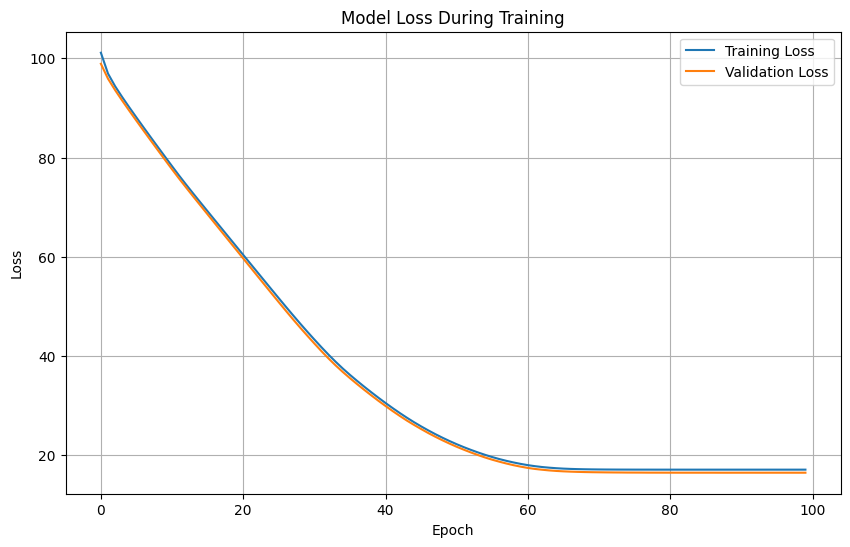

In [35]:
# Build the LSTM Autoencoder model
def create_lstm_autoencoder(input_shape, encoding_dim=16):
    """
    Create a simplified LSTM autoencoder model to reduce overfitting.

    Parameters:
    - input_shape: Shape of input data (sequence_length, n_features)
    - encoding_dim: Dimension of the encoded representation

    Returns:
    - autoencoder: The complete autoencoder model
    - encoder: The encoder part of the model
    """
    # Encoder
    inputs = Input(shape=input_shape)
    encoded = LSTM(32, return_sequences=True, activation='tanh')(inputs)  # Reduced from 64 → 32
    encoded = Dropout(0.1)(encoded)  # Reduced dropout to 0.1
    encoded = LSTM(encoding_dim, return_sequences=False, activation='tanh')(encoded)  # Changed activation to tanh

    # Decoder
    decoded = RepeatVector(input_shape[0])(encoded)
    decoded = LSTM(encoding_dim, return_sequences=True, activation='tanh')(decoded)
    decoded = Dropout(0.1)(decoded)  # Same dropout as encoder
    decoded = LSTM(32, return_sequences=True, activation='tanh')(decoded)  # Reduced from 64 → 32
    decoded = TimeDistributed(Dense(input_shape[-1]))(decoded)  # Fixed n_features reference

    # Autoencoder model
    autoencoder = Model(inputs, decoded)

    # Encoder model
    encoder = Model(inputs, encoded)

    return autoencoder, encoder

# Get the input shape from the training data
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, n_features)

# Create the autoencoder model
autoencoder, encoder = create_lstm_autoencoder(input_shape)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mae')

# Print model summary
autoencoder.summary()

# Train the model with early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_autoencoder.keras', monitor='val_loss', save_best_only=True)

history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# Evaluating Anomaly Threshold on Data

97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Anomaly threshold: 35.81118516344055
Number of anomalies detected: 45
Percentage of anomalies: 5.84%


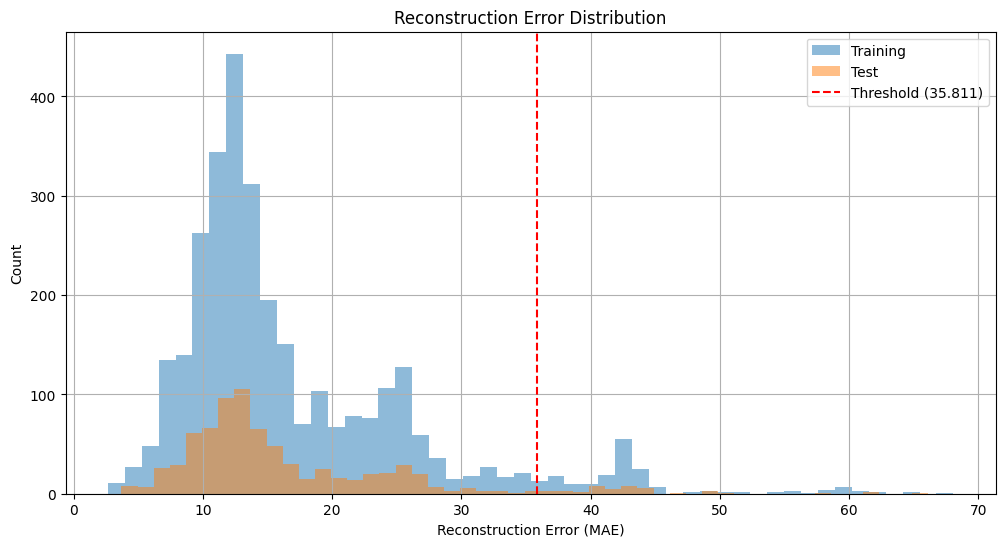

In [36]:
# Calculate reconstruction error on training data
train_pred = autoencoder.predict(X_train)
train_mae = np.mean(np.abs(X_train - train_pred), axis=(1, 2))

# Calculate reconstruction error on test data
test_pred = autoencoder.predict(X_test)
test_mae = np.mean(np.abs(X_test - test_pred), axis=(1, 2))

# Determine the anomaly threshold
# Using mean + 2*std as a starting threshold
threshold = np.mean(train_mae) + 2 * np.std(train_mae)
print(f"Anomaly threshold: {threshold}")

# Identify anomalies in the test set
anomalies = test_mae > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")
print(f"Percentage of anomalies: {np.sum(anomalies) / len(test_mae) * 100:.2f}%")

# Visualization of reconstruction error
plt.figure(figsize=(12, 6))
plt.hist(train_mae, bins=50, alpha=0.5, label='Training')
plt.hist(test_mae, bins=50, alpha=0.5, label='Test')
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.3f})')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error (MAE)')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig('reconstruction_error_distribution.png')
plt.show()

# Visualizations on Normal and Anomalous Videos


Visualizing 3 normal examples:


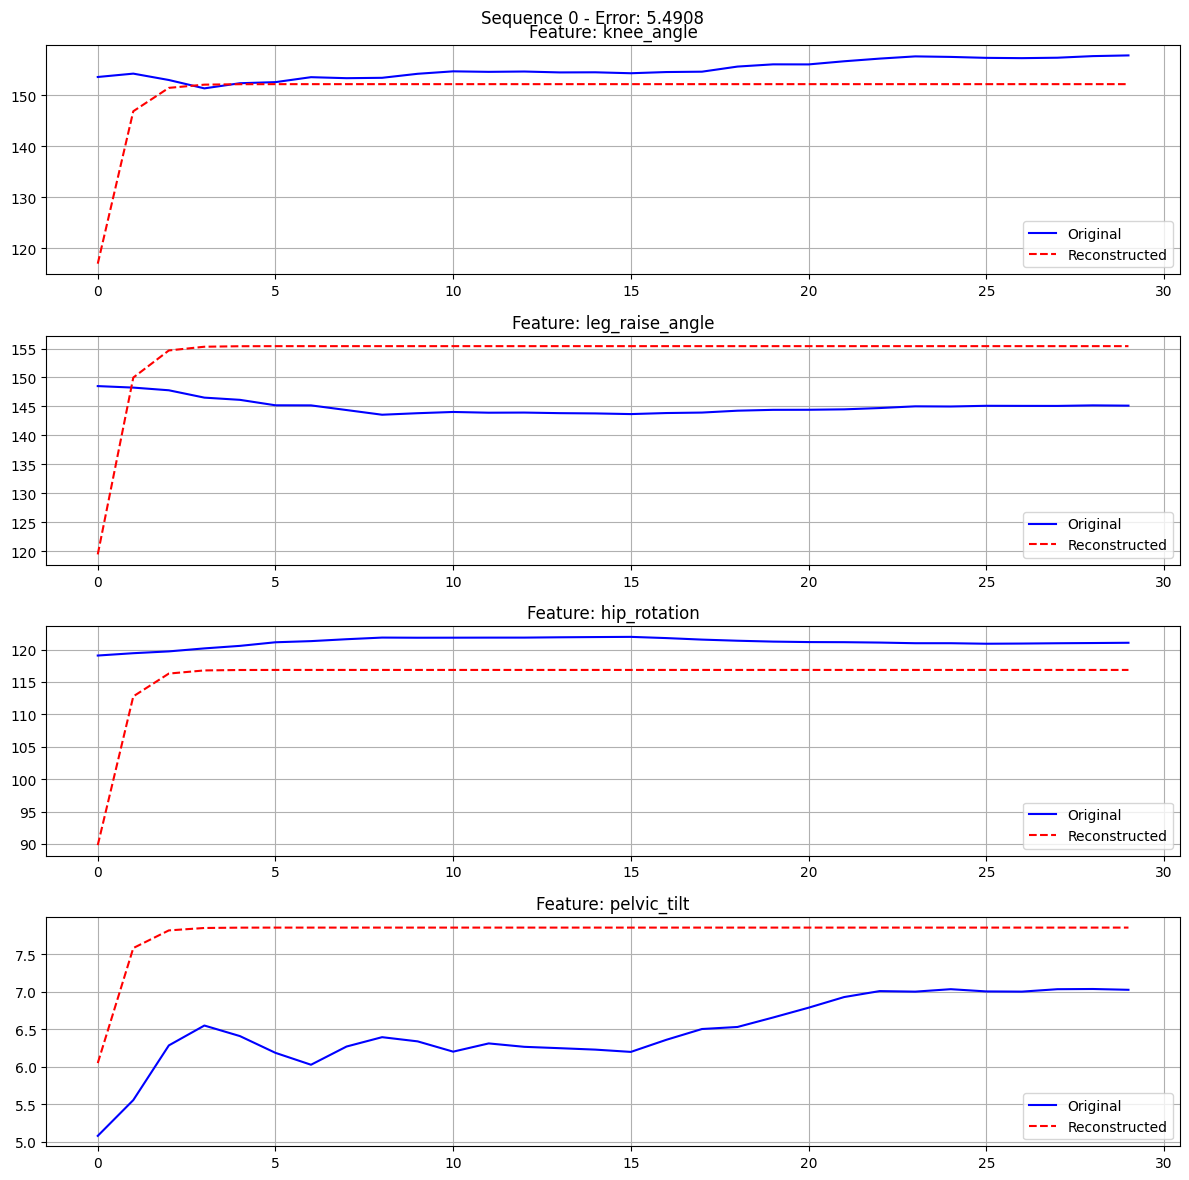

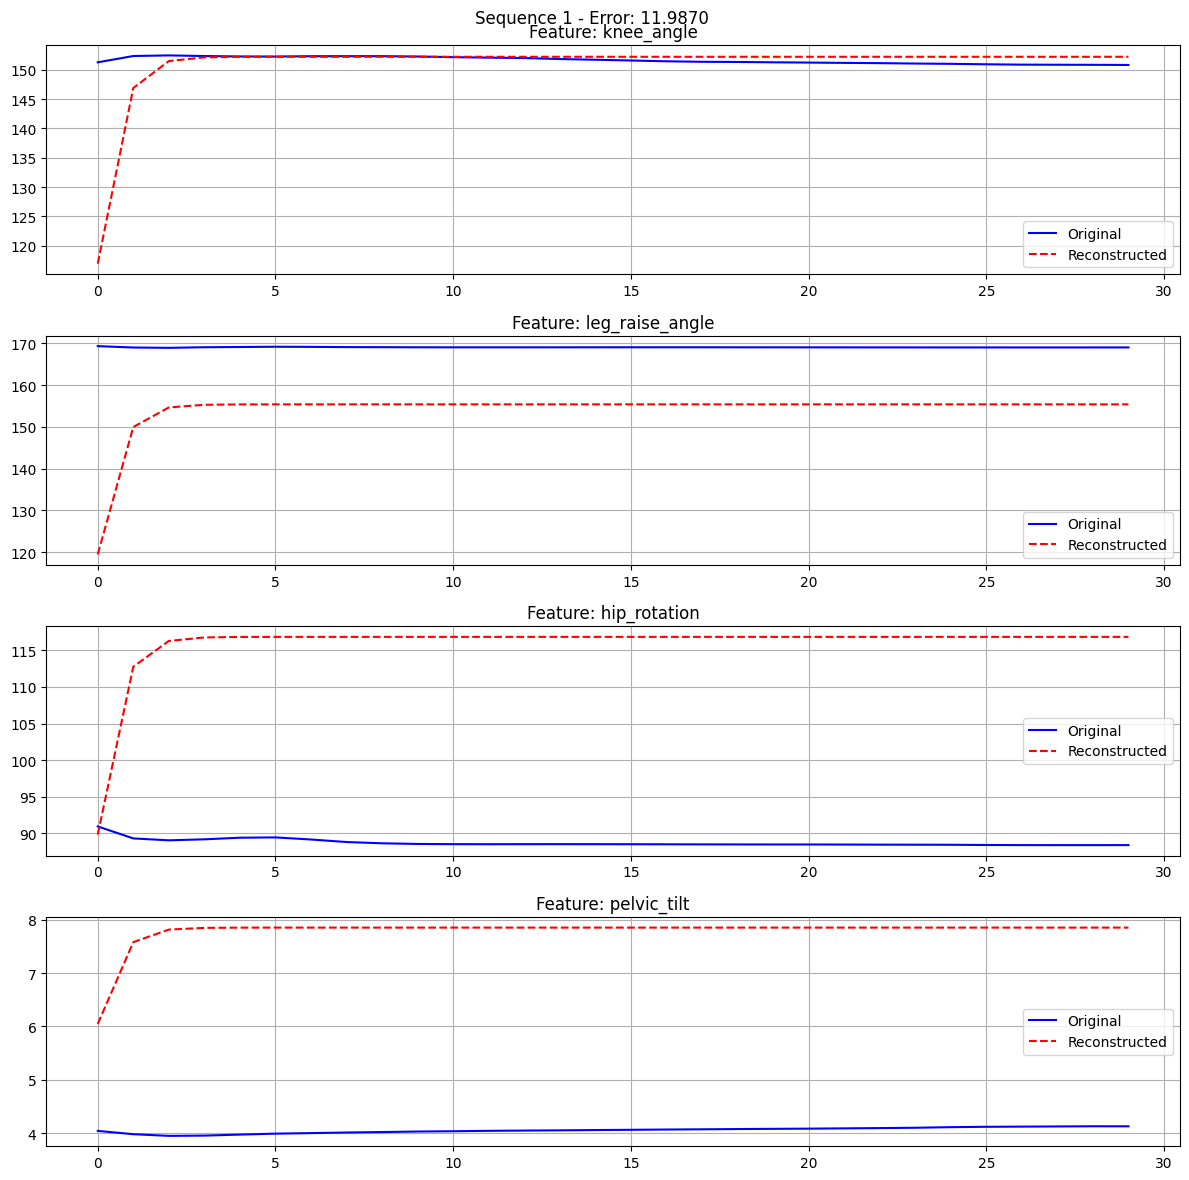

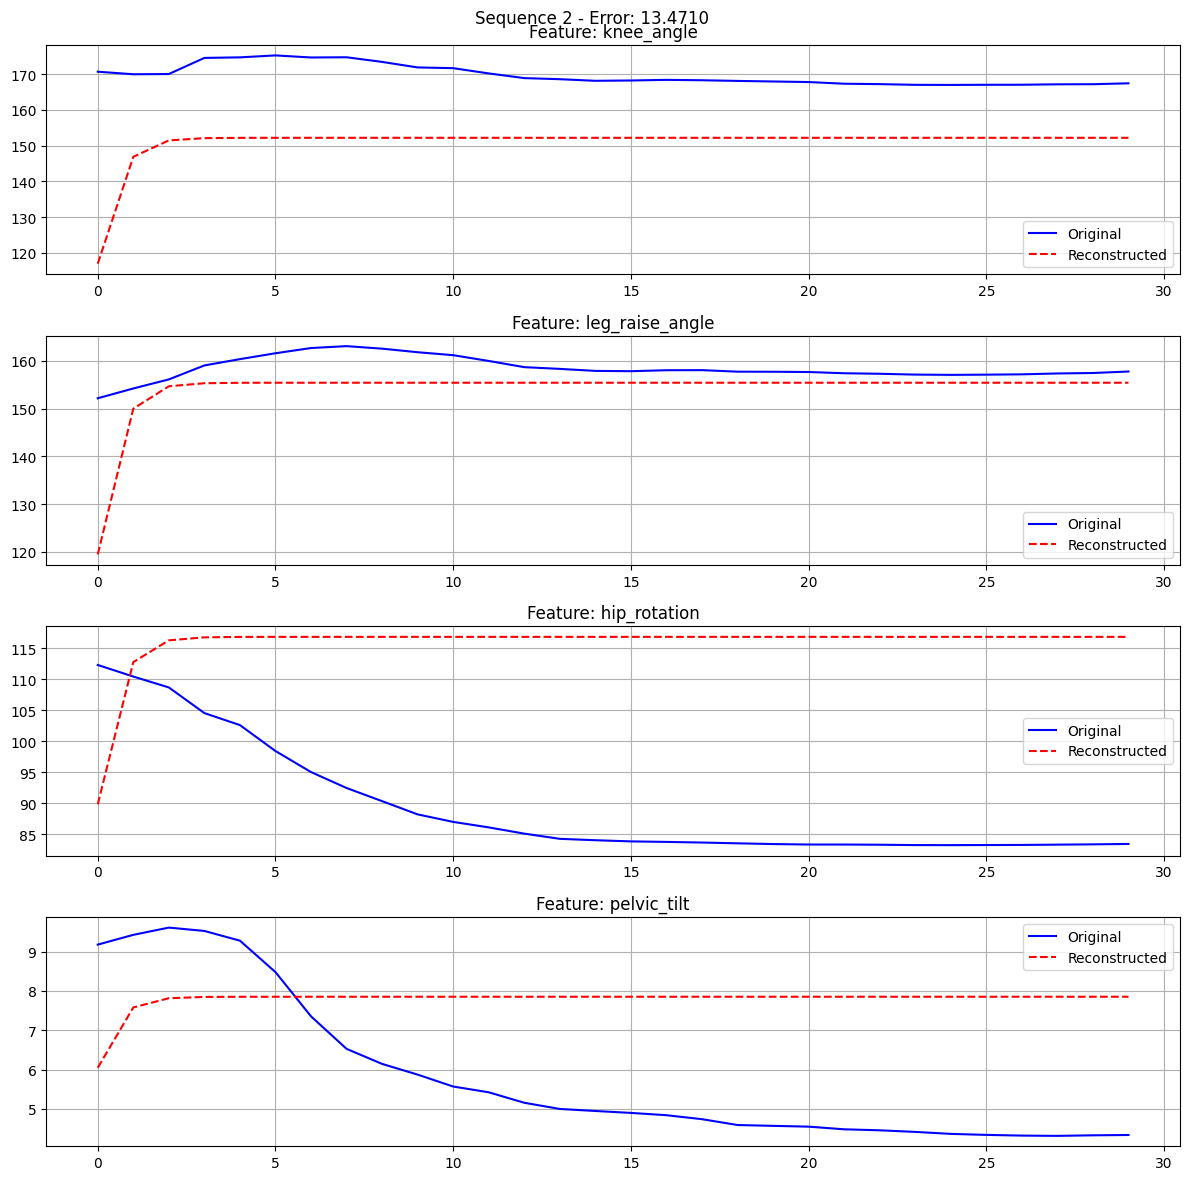


Visualizing 3 anomalous examples:


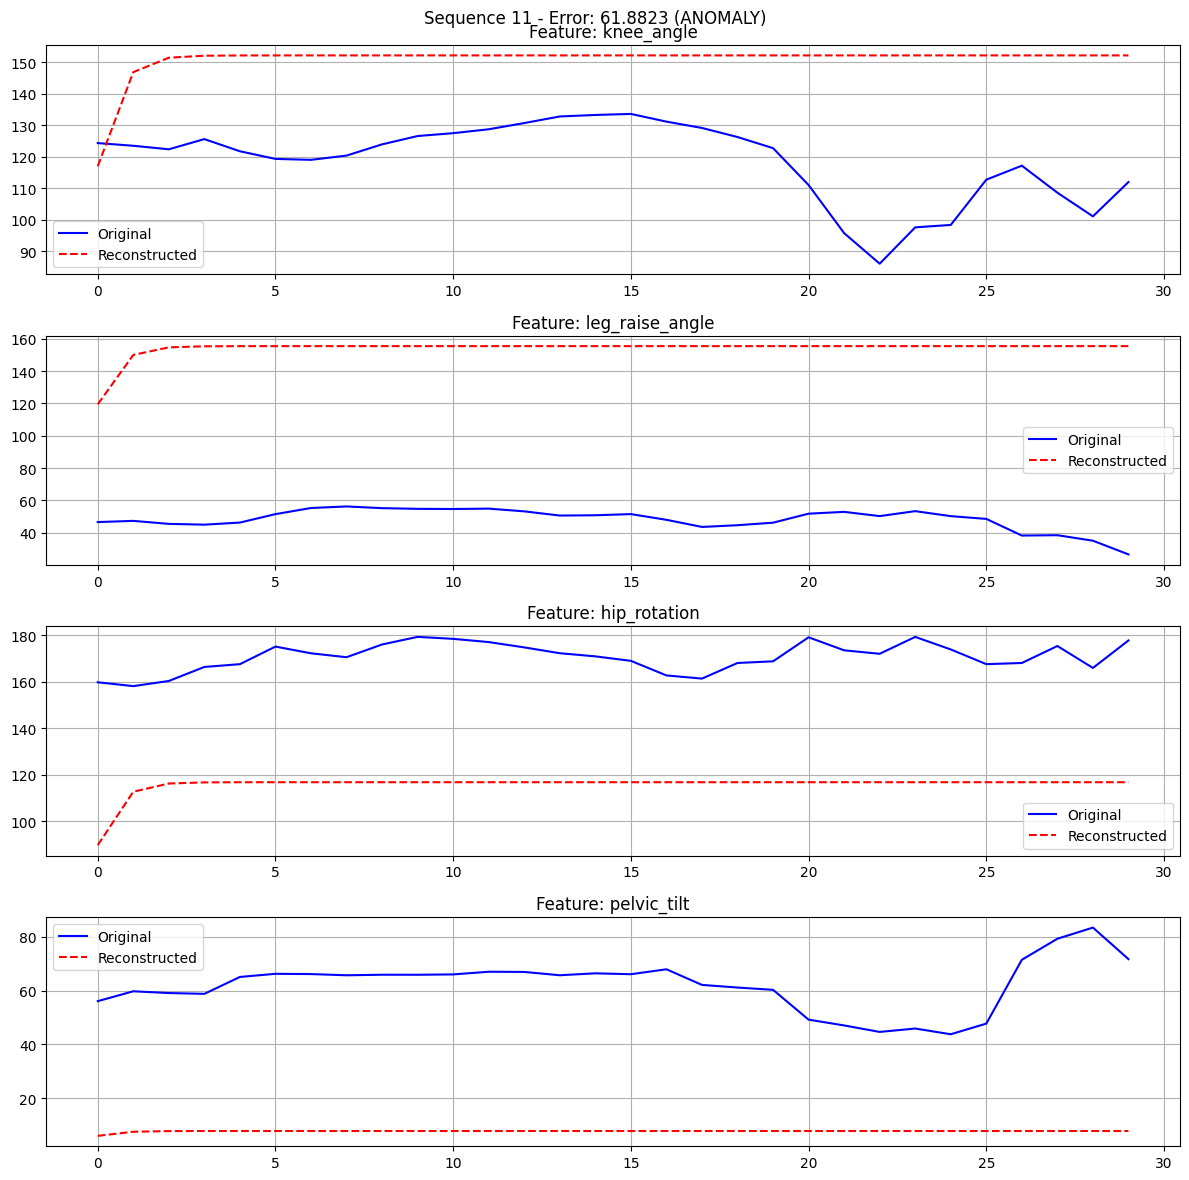

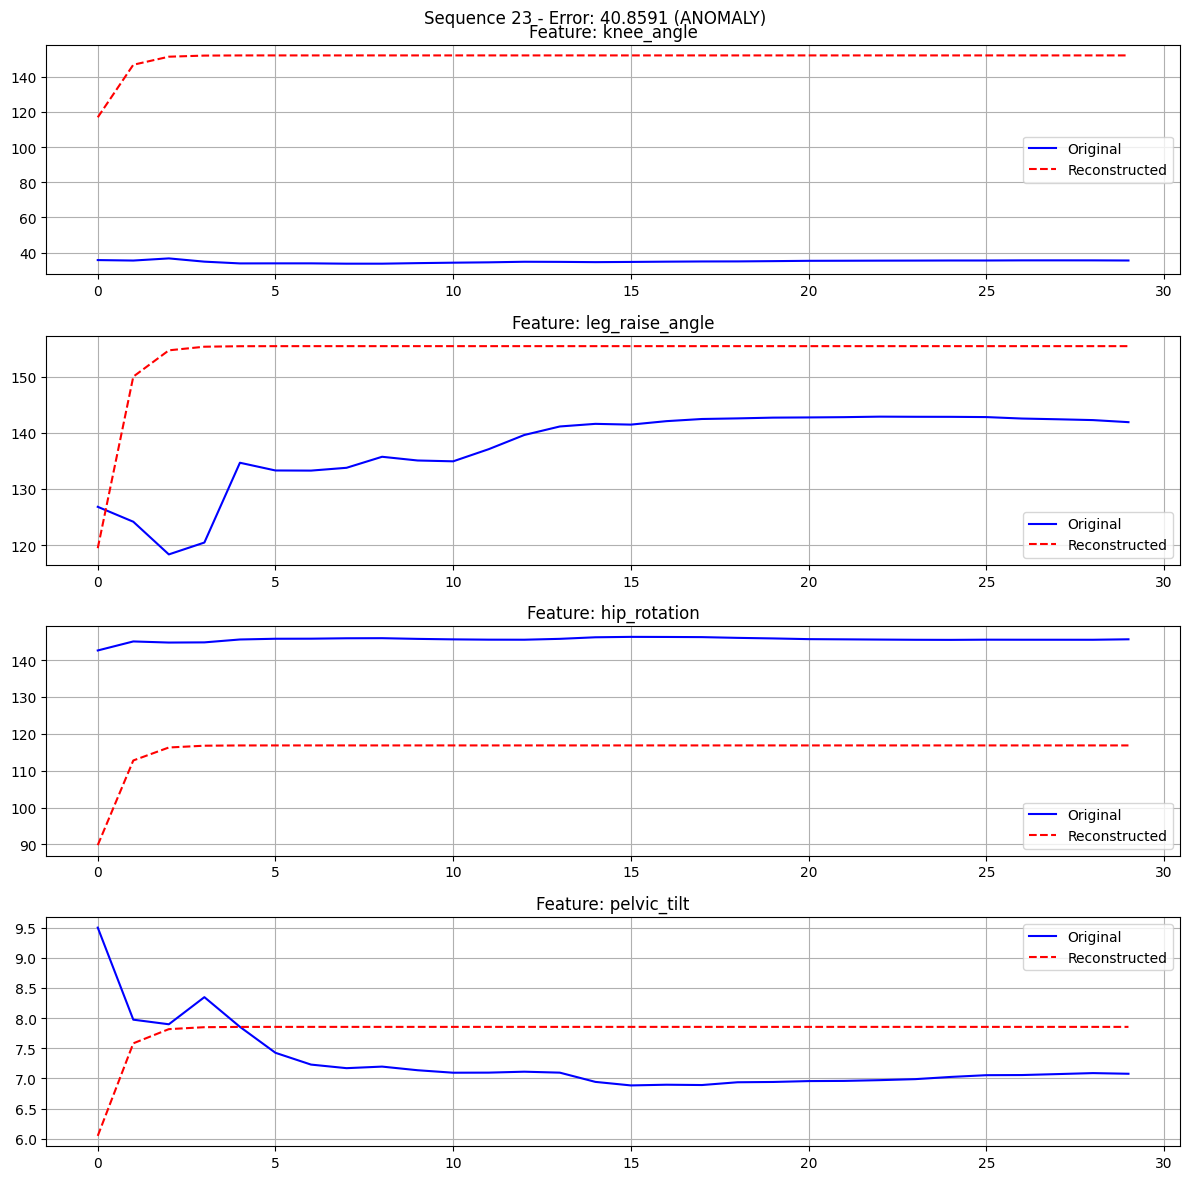

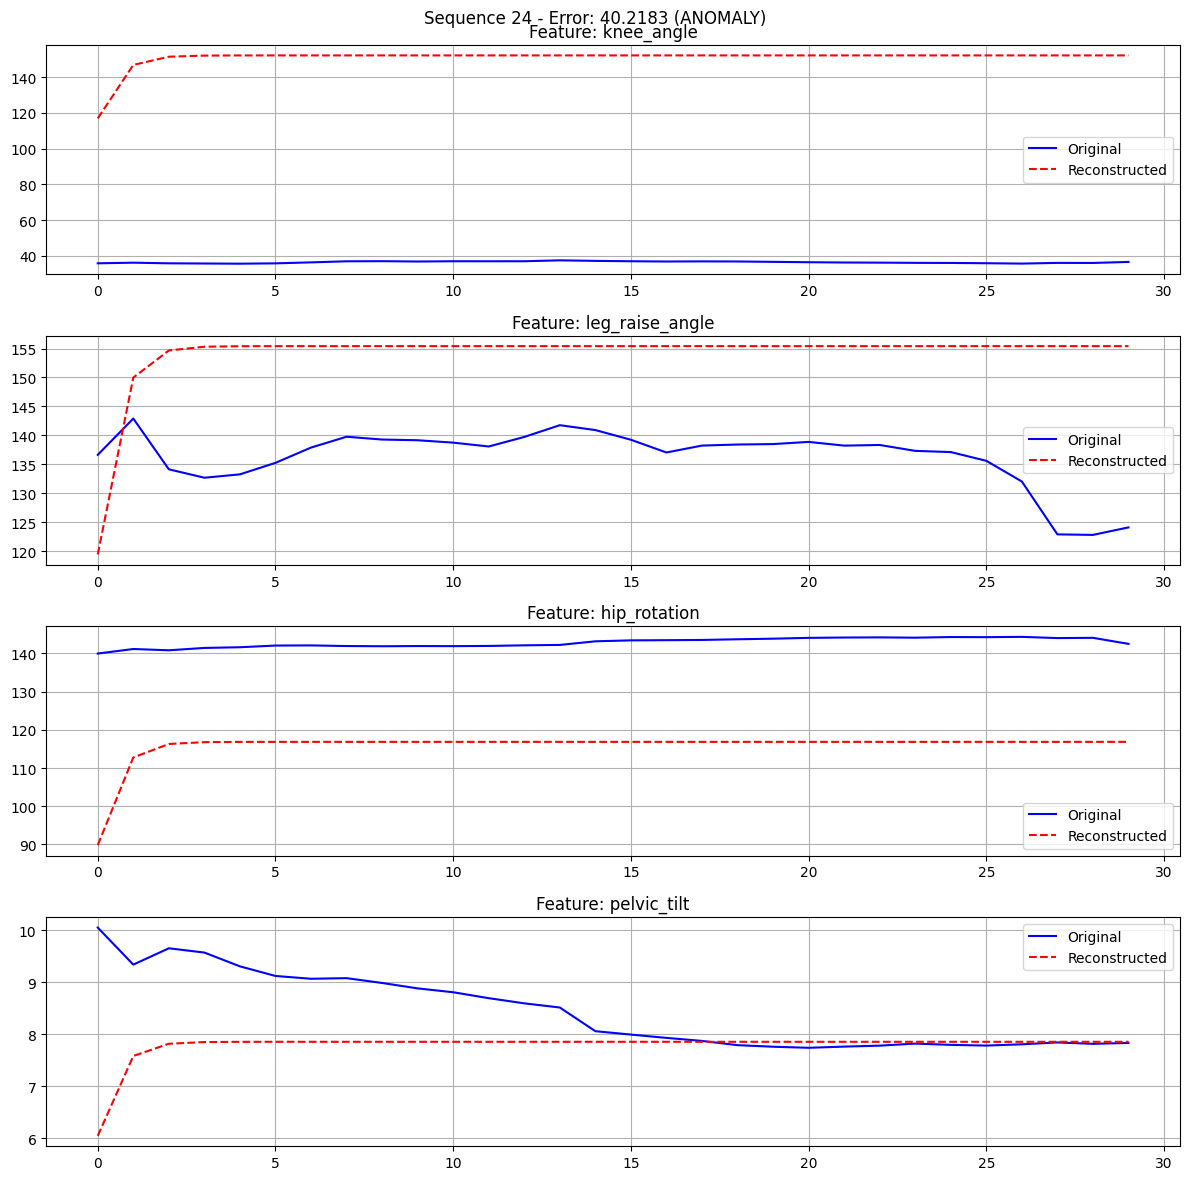

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Example Anomaly Detection:
Is anomalous: False
Error: 5.4908
Feedback:
  Is correct: True
  Overall error: 5.4908

Model and threshold saved for future use.


In [37]:
# Create a function to visualize sequences and their reconstructions
def visualize_sequence_reconstruction(sequence_idx, original, reconstructed, error):
    """
    Visualize original sequence vs. reconstructed sequence
    
    Parameters:
    - sequence_idx: Index of the sequence to visualize
    - original: Original sequence data
    - reconstructed: Reconstructed sequence data from autoencoder
    - error: Reconstruction error
    """
    seq_original = original[sequence_idx]
    seq_reconstructed = reconstructed[sequence_idx]
    
    # Get the feature names (assuming columns in features_df match the sequence features)
    feature_names = feature_columns
    
    # Select a subset of features to visualize (first 6 for example)
    if len(feature_names) > 6:
        selected_features = feature_names[:6]
    else:
        selected_features = feature_names
    
    # Create the plot
    fig, axes = plt.subplots(len(selected_features), 1, figsize=(12, 3 * len(selected_features)))
    
    for i, feature in enumerate(range(min(len(selected_features), seq_original.shape[1]))):
        if len(selected_features) > 1:
            ax = axes[i]
        else:
            ax = axes
            
        ax.plot(seq_original[:, feature], 'b-', label='Original')
        ax.plot(seq_reconstructed[:, feature], 'r--', label='Reconstructed')
        if i < len(selected_features):
            ax.set_title(f'Feature: {selected_features[i]}')
        else:
            ax.set_title(f'Feature: {feature}')
        ax.legend()
        ax.grid(True)
    
    plt.suptitle(f'Sequence {sequence_idx} - Error: {error:.4f} {"(ANOMALY)" if error > threshold else ""}')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return fig

# Visualize some normal and anomalous examples
def visualize_examples(original_data, reconstructed_data, errors, threshold, n_examples=3):
    """
    Visualize examples of normal and anomalous sequences
    
    Parameters:
    - original_data: Original sequences
    - reconstructed_data: Reconstructed sequences
    - errors: Reconstruction errors
    - threshold: Anomaly threshold
    - n_examples: Number of examples to visualize for each category
    """
    # Find normal and anomalous examples
    normal_indices = np.where(errors <= threshold)[0]
    anomaly_indices = np.where(errors > threshold)[0]
    
    # Visualize normal examples
    print(f"\nVisualizing {min(n_examples, len(normal_indices))} normal examples:")
    for i in range(min(n_examples, len(normal_indices))):
        idx = normal_indices[i]
        fig = visualize_sequence_reconstruction(idx, original_data, reconstructed_data, errors[idx])
        plt.savefig(f'normal_example_{i}.png')
        plt.show()
    
    # Visualize anomalous examples
    print(f"\nVisualizing {min(n_examples, len(anomaly_indices))} anomalous examples:")
    for i in range(min(n_examples, len(anomaly_indices))):
        idx = anomaly_indices[i]
        fig = visualize_sequence_reconstruction(idx, original_data, reconstructed_data, errors[idx])
        plt.savefig(f'anomaly_example_{i}.png')
        plt.show()

# Visualize examples
visualize_examples(X_test, test_pred, test_mae, threshold, n_examples=3)

# Create a function for real-time anomaly detection
def detect_exercise_anomaly(sequence, model, threshold):
    """
    Detect anomalies in a new exercise sequence
    
    Parameters:
    - sequence: New exercise sequence (should match input shape used for training)
    - model: Trained autoencoder model
    - threshold: Anomaly threshold
    
    Returns:
    - is_anomaly: Boolean indicating if the sequence is anomalous
    - error: Reconstruction error
    - feedback: Dictionary containing feedback on specific issues
    """
    # Ensure sequence has the right shape (add batch dimension if needed)
    if len(sequence.shape) == 2:
        sequence = np.expand_dims(sequence, axis=0)
    
    # Get reconstruction and error
    reconstructed = model.predict(sequence)
    error = np.mean(np.abs(sequence - reconstructed), axis=(1, 2))[0]
    
    # Determine if anomalous
    is_anomaly = error > threshold
    
    # Generate feedback (this would need to be customized for your specific features)
    feedback = {
        "is_correct": not is_anomaly,
        "overall_error": error,
        "specific_issues": []
    }
    
    # If anomalous, analyze which features contribute most to the error
    if is_anomaly:
        # Calculate error per feature
        feature_errors = np.mean(np.abs(sequence - reconstructed), axis=1)[0]
        
        # Get feature names (assuming they match features_df columns)
        feature_names = feature_columns
        
        # Identify top 3 problematic features
        top_issues = np.argsort(feature_errors)[-3:]
        
        for issue_idx in top_issues:
            if issue_idx < len(feature_names):
                feedback["specific_issues"].append({
                    "feature": feature_names[issue_idx],
                    "error": feature_errors[issue_idx],
                    "suggestion": f"Pay attention to your {feature_names[issue_idx].replace('_', ' ')}"
                })
    
    return is_anomaly, error, feedback

# Running Anomaly Detcetion on Test set
example_idx = 0
example_sequence = X_test[example_idx:example_idx+1]
is_anomaly, error, feedback = detect_exercise_anomaly(example_sequence, autoencoder, threshold)

print("\nExample Anomaly Detection:")
print(f"Is anomalous: {is_anomaly}")
print(f"Error: {error:.4f}")
print("Feedback:")
print(f"  Is correct: {feedback['is_correct']}")
print(f"  Overall error: {feedback['overall_error']:.4f}")
if feedback["specific_issues"]:
    print("  Specific issues:")
    for issue in feedback["specific_issues"]:
        print(f"    - {issue['feature']}: {issue['suggestion']} (Error: {issue['error']:.4f})")

# Save the model and threshold for future use
autoencoder.save('leg_raise_autoencoder.h5')
np.save('anomaly_threshold.npy', threshold)

print("\nModel and threshold saved for future use.")

In [24]:
def print_csv_headers(file_path):
    """Prints the column headers of a CSV file."""
    try:
        df = pd.read_csv(file_path, nrows=0)  # Read only the header row
        print("CSV Headers:", list(df.columns))
    except Exception as e:
        print("Error:", e)

# Example usage
print_csv_headers("leg_raise_features_3d.csv")
print_csv_headers("sequence_metadata.csv")


CSV Headers: ['video_id', 'frame_number', 'side', 'knee_angle', 'leg_raise_angle', 'hip_rotation', 'pelvic_tilt', 'torso_stability']
CSV Headers: ['video_id', 'start_frame', 'end_frame', 'side']
